In [1]:
%run beeper.ipynb
%run fetch_data.ipynb
%run transform.ipynb

Fetching indicator: Return on Assets (ROA) (%)
Fetching indicator: Capital to Risk-Weighted Assets (%)
Fetching indicator: Capital to Assets Ratio (%)
Fetching indicator: Return on Equity (ROE) (%)
Fetching indicator: Interest Income to Total Income (%)
Collected 20649 rows of ESG/Risk data and saved to 'esg_risk_data.csv'
Merged dataset saved with 20649 rows.
Process complete!
 Total rows: 20649
 Preview:
  country country_name   indicator              indicator_name  year     value
0      AF  Afghanistan  GFDD.EI.03  Return on Assets (ROA) (%)  2021  79.01166
1      AF  Afghanistan  GFDD.EI.03  Return on Assets (ROA) (%)  2020  60.56100
2      AF  Afghanistan  GFDD.EI.03  Return on Assets (ROA) (%)  2019  57.19835
3      AF  Afghanistan  GFDD.EI.03  Return on Assets (ROA) (%)  2018  59.15955
4      AF  Afghanistan  GFDD.EI.03  Return on Assets (ROA) (%)  2017  53.93527


In [2]:
# from dotenv import load_dotenv

import keyring
from snowflake.snowpark import Session

connection_parameters = {
    "account": "XOUIBXC-YI47609",
    "user": "ADITHYA",
    "password": keyring.get_password("snowflake", "ADITHYA"),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "BANK_DATA",
    "schema": "RAW_DATA"
}

session = Session.builder.configs(connection_parameters).create()
print(" Connection successful")

session.write_pandas(df, table_name="BANK_ESG_RISK", auto_create_table=True, overwrite=True)

print(f" Uploaded {len(df)} records to BANK_DATA.RAW_DATA.BANK_ESG_RISK")


 Connection successful
 Uploaded 20649 records to BANK_DATA.RAW_DATA.BANK_ESG_RISK


In [3]:
create_view_sql = """
create or replace view RAW_DATA.stg_esg_risk as
select
  "country",
  "country_name",
  "indicator",
  "indicator_name",
  try_cast("year" as int) as year,
  try_cast("value" as float) as value
from RAW_DATA.BANK_ESG_RISK
where "value" is not null
"""
session.sql(create_view_sql).collect()
print("Created view: stg_esg_risk")


Created view: stg_esg_risk


In [4]:
print(session.table("RAW_DATA.stg_esg_risk").columns)
create_fact_view_sql = """
create or replace view RAW_DATA.fct_esg_summary as
select
  "country",
  YEAR as year,
  "indicator_name",
  avg(VALUE) as avg_value
from RAW_DATA.stg_esg_risk
where VALUE is not null
group by "country", YEAR, "indicator_name"
"""
session.sql(create_fact_view_sql).collect()
print("Created view: fct_esg_summary")


['"country"', '"country_name"', '"indicator"', '"indicator_name"', 'YEAR', 'VALUE']
Created view: fct_esg_summary


In [5]:
query = """
SELECT "country", "country_name", COUNT(*) as record_count
FROM RAW_DATA.BANK_ESG_RISK
GROUP BY "country", "country_name"
ORDER BY record_count DESC
LIMIT 1000
"""
df = session.sql(query).to_pandas()
print(df)


    country           country_name  RECORD_COUNT
0        MY               Malaysia           151
1        BR                 Brazil           151
2        NO                 Norway           151
3        IN                  India           151
4        PK               Pakistan           151
..      ...                    ...           ...
188      TL            Timor-Leste            20
189      XK                 Kosovo            14
190      ST  São Tomé and Principe            12
191      MC                 Monaco             9
192      KP       Korea, Dem. Rep.             3

[193 rows x 3 columns]


In [6]:
query = """
SELECT 
    "country",
    "country_name",
    COUNT(DISTINCT "indicator") AS num_indicators,
    COUNT(DISTINCT "year") AS num_years,
    AVG("value") AS avg_value,
    MIN("value") AS min_value,
    MAX("value") AS max_value
FROM RAW_DATA.BANK_ESG_RISK
WHERE "value" IS NOT NULL
GROUP BY "country", "country_name"
ORDER BY avg_value DESC
"""
df_country_stats = session.sql(query).to_pandas()
print(df_country_stats.head())


  country          country_name  NUM_INDICATORS  NUM_YEARS   AVG_VALUE  \
0      LU            Luxembourg               5         61  103.953265   
1      KN   St. Kitts and Nevis               2         43   88.918177   
2      HK  Hong Kong SAR, China               5         31   82.380355   
3      VU               Vanuatu               2         43   72.366350   
4      JP                 Japan               5         62   71.661989   

   MIN_VALUE  MAX_VALUE  
0   0.100000   462.1295  
1  55.415290   138.6620  
2   0.510000   415.7495  
3   4.771505   123.7953  
4   0.441660   259.6056  


In [7]:
query = """
SELECT 
    "country",
    "country_name",
    COUNT(DISTINCT "indicator") AS num_indicators,
    COUNT(DISTINCT "year") AS num_years,
    AVG("value") AS avg_value,
    MIN("value") AS min_value,
    MAX("value") AS max_value
FROM RAW_DATA.BANK_ESG_RISK
GROUP BY "country", "country_name"
ORDER BY num_indicators DESC, avg_value DESC
"""
df_all_countries = session.sql(query).to_pandas()
print(f"Total countries: {len(df_all_countries)}")
print(df_all_countries.head(10))


Total countries: 193
  country          country_name  NUM_INDICATORS  NUM_YEARS   AVG_VALUE  \
0      LU            Luxembourg               5         61  103.953265   
1      HK  Hong Kong SAR, China               5         31   82.380355   
2      JP                 Japan               5         62   71.661989   
3      LB               Lebanon               5         34   59.315126   
4      MO      Macao SAR, China               5         38   58.203685   
5      CH           Switzerland               5         52   50.713750   
6      MT                 Malta               5         52   49.564309   
7      MR            Mauritania               5         52   47.575744   
8      CY                Cyprus               5         47   43.503117   
9      MY              Malaysia               5         62   42.921575   

   MIN_VALUE  MAX_VALUE  
0   0.100000   462.1295  
1   0.510000   415.7495  
2   0.441660   259.6056  
3   1.154261   250.3682  
4   0.092335   346.5976  
5   0.30

In [8]:
clean_sql = """
SELECT *
FROM RAW_DATA.STAGING_BANK_ESG_RISK
"""
clean_sql_sess = session.sql(clean_sql).to_pandas()
print(clean_sql_sess)


    country           country_name  RECORD_COUNT
0        MY               Malaysia           151
1        BR                 Brazil           151
2        NO                 Norway           151
3        IN                  India           151
4        PK               Pakistan           151
..      ...                    ...           ...
188      TL            Timor-Leste            20
189      XK                 Kosovo            14
190      ST  São Tomé and Principe            12
191      MC                 Monaco             9
192      KP       Korea, Dem. Rep.             3

[193 rows x 3 columns]


In [9]:
session.table("RAW_DATA.STAGING_BANK_ESG_RISK").columns
# Output: ['"country"', '"country_name"', 'RECORD_COUNT']


['"country"', '"country_name"', 'RECORD_COUNT']

In [10]:
clean_sql = """
CREATE OR REPLACE TABLE RAW_DATA.BANK_ESG_RISK AS
SELECT DISTINCT *
FROM RAW_DATA.STAGING_BANK_ESG_RISK
"""
session.sql(clean_sql).collect()
print("Cleaned and reloaded data into BANK_ESG_RISK.")


Cleaned and reloaded data into BANK_ESG_RISK.


In [12]:
import pandas as pd
import keyring
from snowflake.snowpark import Session

connection_parameters = {
    "account": "XOUIBXC-YI47609",
    "user": "ADITHYA",
    "password": keyring.get_password("snowflake", "ADITHYA"),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "BANK_DATA",
    "schema": "RAW_DATA"
}

session = Session.builder.configs(connection_parameters).create()
print(" Connection successful")

# Upload enriched data
session.write_pandas(df, table_name="BANK_ESG_RISK", auto_create_table=True, overwrite=True)

print(f" Uploaded {len(df)} enriched records to Snowflake.")


 Connection successful
 Uploaded 20442 enriched records to Snowflake.


In [13]:
query = """
SELECT "country_name", "indicator_name", AVG("value") AS avg_value
FROM RAW_DATA.BANK_ESG_RISK
WHERE "indicator_name" IN ('Return on Assets (ROA) (%)', 'Return on Equity (ROE) (%)')
GROUP BY "country_name", "indicator_name"
ORDER BY avg_value DESC
LIMIT 20
"""
df_top_returns = session.sql(query).to_pandas()
print(df_top_returns)


           country_name              indicator_name  AVG_VALUE
0           South Sudan  Return on Assets (ROA) (%)  78.885373
1               Andorra  Return on Assets (ROA) (%)  74.772366
2   St. Kitts and Nevis  Return on Assets (ROA) (%)  71.918460
3           Congo, Rep.  Return on Assets (ROA) (%)  68.057090
4           Switzerland  Return on Assets (ROA) (%)  67.536580
5                 Sudan  Return on Assets (ROA) (%)  61.491908
6                Monaco  Return on Assets (ROA) (%)  58.587850
7                  Togo  Return on Assets (ROA) (%)  58.155645
8                  Iraq  Return on Assets (ROA) (%)  57.064007
9            Uzbekistan  Return on Assets (ROA) (%)  56.813441
10   Russian Federation  Return on Assets (ROA) (%)  56.502062
11             Zimbabwe  Return on Assets (ROA) (%)  56.459841
12               France  Return on Assets (ROA) (%)  55.577086
13     Congo, Dem. Rep.  Return on Assets (ROA) (%)  55.046534
14               Guinea  Return on Assets (ROA) (%)  54

In [14]:
session.table("RAW_DATA.BANK_ESG_RISK").columns


['"country"',
 '"country_name"',
 '"indicator"',
 '"indicator_name"',
 '"year"',
 '"value"',
 '"gdp"',
 '"population"']

In [15]:
query = """
SELECT 
    "country_name",
    "indicator_name",
    AVG("value") AS avg_esg,
    AVG("gdp") AS avg_gdp
FROM RAW_DATA.BANK_ESG_RISK
WHERE "gdp" IS NOT NULL AND "value" IS NOT NULL
GROUP BY "country_name", "indicator_name"
ORDER BY avg_gdp DESC
LIMIT 50
"""
df_gdp_esg = session.sql(query).to_pandas()


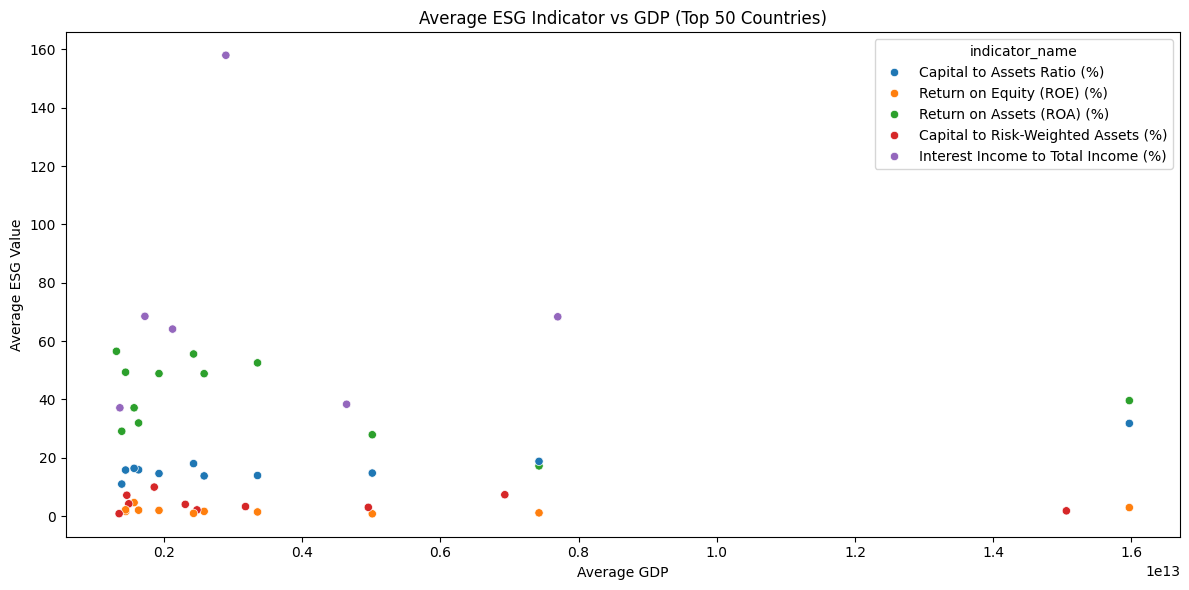

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_gdp_esg, x="AVG_GDP", y="AVG_ESG", hue="indicator_name")
plt.title("Average ESG Indicator vs GDP (Top 50 Countries)")
plt.xlabel("Average GDP")
plt.ylabel("Average ESG Value")
plt.tight_layout()
plt.show()


In [17]:
top_esg = df.groupby("country_name")["value"].mean().reset_index(name="avg_esg")
top_esg = top_esg.sort_values("avg_esg", ascending=False).head(10)
print(top_esg)


             country_name     avg_esg
103            Luxembourg  103.953265
158   St. Kitts and Nevis   88.918177
77   Hong Kong SAR, China   82.380355
184               Vanuatu   72.366350
88                  Japan   71.661989
52               Dominica   63.196234
187    West Bank and Gaza   60.598244
98                Lebanon   59.315126
104      Macao SAR, China   58.203685
70                Grenada   58.089369


In [18]:
volatility = df.groupby("indicator_name")["value"].std().reset_index(name="volatility")
volatility = volatility.sort_values("volatility", ascending=False)
print(volatility)


                        indicator_name  volatility
2  Interest Income to Total Income (%)   40.627851
3           Return on Assets (ROA) (%)   13.776979
0          Capital to Assets Ratio (%)    9.750630
1  Capital to Risk-Weighted Assets (%)    7.574944
4           Return on Equity (ROE) (%)    3.042572


In [19]:
correlations = df[["indicator_name", "value", "gdp"]].dropna()
corr_result = correlations.groupby("indicator_name").apply(
    lambda x: x["value"].corr(x["gdp"])
).reset_index(name="gdp_esg_correlation")
corr_result = corr_result.sort_values("gdp_esg_correlation", key=abs, ascending=False)
print(corr_result)


                        indicator_name  gdp_esg_correlation
2  Interest Income to Total Income (%)             0.180581
1  Capital to Risk-Weighted Assets (%)            -0.148120
4           Return on Equity (ROE) (%)            -0.108546
0          Capital to Assets Ratio (%)             0.100936
3           Return on Assets (ROA) (%)            -0.010750


C:\Users\riber\AppData\Local\Temp\ipykernel_23268\1036076456.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_result = correlations.groupby("indicator_name").apply(


In [20]:
improvement = df.dropna(subset=["value", "year"]).copy()
improvement["year"] = improvement["year"].astype(int)
first = improvement.sort_values("year").groupby(["country_name", "indicator_name"]).first().reset_index()
last = improvement.sort_values("year").groupby(["country_name", "indicator_name"]).last().reset_index()

change = pd.merge(last, first, on=["country_name", "indicator_name"], suffixes=("_last", "_first"))
change["improvement"] = change["value_last"] - change["value_first"]
top_improvements = change.sort_values("improvement", ascending=False).head(10)
print(top_improvements[["country_name", "indicator_name", "improvement"]])


             country_name                       indicator_name  improvement
452            Luxembourg  Interest Income to Total Income (%)   389.474710
333  Hong Kong SAR, China  Interest Income to Total Income (%)   233.301400
384                 Japan  Interest Income to Total Income (%)   215.820530
457      Macao SAR, China  Interest Income to Total Income (%)   205.983590
404           Korea, Rep.  Interest Income to Total Income (%)   155.075739
137              Cambodia  Interest Income to Total Income (%)   128.539806
496             Mauritius  Interest Income to Total Income (%)   126.992740
751              Thailand  Interest Income to Total Income (%)   122.809800
537                 Nepal  Interest Income to Total Income (%)   107.591856
472              Malaysia  Interest Income to Total Income (%)   107.056030


In [21]:
esg_per_capita = df.groupby("country_name").apply(
    lambda x: x["value"].sum() / x["population"].mean()
).reset_index(name="esg_per_capita")

esg_per_capita = esg_per_capita.sort_values("esg_per_capita", ascending=False).head(10)
print(esg_per_capita)


                       country_name  esg_per_capita
144                      San Marino        0.094871
158             St. Kitts and Nevis        0.087933
5               Antigua and Barbuda        0.043272
52                         Dominica        0.040724
148                      Seychelles        0.040136
103                      Luxembourg        0.031375
70                          Grenada        0.027834
160  St. Vincent and the Grenadines        0.025275
8                             Aruba        0.022353
184                         Vanuatu        0.018228


C:\Users\riber\AppData\Local\Temp\ipykernel_23268\1600975142.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  esg_per_capita = df.groupby("country_name").apply(


In [22]:
from dotenv import load_dotenv

import keyring
from snowflake.snowpark import Session

connection_parameters = {
    "account": "XOUIBXC-YI47609",
    "user": "ADITHYA",
    "password": keyring.get_password("snowflake", "ADITHYA"),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "BANK_DATA",
    "schema": "RAW_DATA"
}

session = Session.builder.configs(connection_parameters).create()
print(" Connection successful")

# Create export folder if not exists
os.makedirs("powerbi_exports", exist_ok=True)

# Export RAW_DATA.fct_esg_summary
df_summary = session.table("RAW_DATA.fct_esg_summary").to_pandas()
df_summary.to_csv("powerbi_exports/esg_summary_export.csv", index=False)
print(" Exported: esg_summary_export.csv")

# Export RAW_DATA.stg_esg_risk
df_stg = session.table("RAW_DATA.stg_esg_risk").to_pandas()
df_stg.to_csv("powerbi_exports/stg_esg_risk_export.csv", index=False)
print(" Exported: stg_esg_risk_export.csv")

# Export RAW_DATA.BANK_ESG_RISK
df_bank = session.table("RAW_DATA.BANK_ESG_RISK").to_pandas()
df_bank.to_csv("powerbi_exports/bank_esg_risk_export.csv", index=False)
print(" Exported: bank_esg_risk_export.csv")

# Alternative for live connection:
# In Power BI Desktop > Get Data > Snowflake > Use same credentials as .env


 Connection successful
 Exported: esg_summary_export.csv
 Exported: stg_esg_risk_export.csv
 Exported: bank_esg_risk_export.csv


Process complete!


In [26]:
# Step-by-step Python guidance to connect Snowflake to Power BI (indirect method)

# There are 2 practical ways:
# 1. Export dataframes to CSV and use Power BI Desktop to import them.
# 2. Use the Snowflake connector directly in Power BI (best practice).

# Here's how to make sure your Snowflake tables are ready for Power BI:

import keyring
from snowflake.snowpark import Session

connection_parameters = {
    "account": "XOUIBXC-YI47609",
    "user": "ADITHYA",
    "password": keyring.get_password("snowflake", "ADITHYA"),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "BANK_DATA",
    "schema": "RAW_DATA"
}

session = Session.builder.configs(connection_parameters).create()
print(" Connection successful")

session = Session.builder.configs(connection_parameters).create()

# Create export folder if not exists
os.makedirs("powerbi_exports", exist_ok=True)

# Export RAW_DATA.fct_esg_summary
df_summary = session.table("RAW_DATA.fct_esg_summary").to_pandas()
df_summary.to_csv("powerbi_exports/esg_summary_export.csv", index=False)
print("Exported: esg_summary_export.csv")

# Export RAW_DATA.stg_esg_risk
df_stg = session.table("RAW_DATA.stg_esg_risk").to_pandas()
df_stg.to_csv("powerbi_exports/stg_esg_risk_export.csv", index=False)
print("Exported: stg_esg_risk_export.csv")

# Export RAW_DATA.BANK_ESG_RISK
df_bank = session.table("RAW_DATA.BANK_ESG_RISK").to_pandas()
df_bank.to_csv("powerbi_exports/bank_esg_risk_export.csv", index=False)
print("Exported: bank_esg_risk_export.csv")

# Alternative for live connection:
# In Power BI Desktop > Get Data > Snowflake > Use same credentials as .env


 Connection successful
Exported: esg_summary_export.csv
Exported: stg_esg_risk_export.csv
Exported: bank_esg_risk_export.csv


In [28]:
# Step-by-step Python guidance to connect Snowflake to Power BI (indirect method)

# There are 2 practical ways:
# 1. Export dataframes to CSV and use Power BI Desktop to import them.
# 2. Use the Snowflake connector directly in Power BI (best practice).

# Here's how to make sure your Snowflake tables are ready for Power BI:

import keyring
from snowflake.snowpark import Session

connection_parameters = {
    "account": "XOUIBXC-YI47609",
    "user": "ADITHYA",
    "password": keyring.get_password("snowflake", "ADITHYA"),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH",
    "database": "BANK_DATA",
    "schema": "RAW_DATA"
}

session = Session.builder.configs(connection_parameters).create()
print(" Connection successful")

# Create export folder if not exists
os.makedirs("powerbi_exports", exist_ok=True)

# Export RAW_DATA.fct_esg_summary
df_summary = session.table("RAW_DATA.fct_esg_summary").to_pandas()
df_summary.to_csv("powerbi_exports/esg_summary_export.csv", index=False)
print("Exported: esg_summary_export.csv")

# Export RAW_DATA.stg_esg_risk
df_stg = session.table("RAW_DATA.stg_esg_risk").to_pandas()
df_stg.to_csv("powerbi_exports/stg_esg_risk_export.csv", index=False)
print("Exported: stg_esg_risk_export.csv")

# Export RAW_DATA.BANK_ESG_RISK
df_bank = session.table("RAW_DATA.BANK_ESG_RISK").to_pandas()
df_bank.to_csv("powerbi_exports/bank_esg_risk_export.csv", index=False)
print("Exported: bank_esg_risk_export.csv")

# Derived analytical DataFrames for Power BI:

# Top ESG scoring countries
top_esg = df_bank.groupby("country_name")["value"].mean().reset_index(name="avg_esg")
top_esg = top_esg.sort_values("avg_esg", ascending=False).head(10)
top_esg.to_csv("powerbi_exports/top_avg_esg.csv", index=False)
print("Exported: top_avg_esg.csv")

# Volatility (std dev) across indicators
volatility = df_bank.groupby("indicator_name")["value"].std().reset_index(name="volatility")
volatility = volatility.sort_values("volatility", ascending=False)
volatility.to_csv("powerbi_exports/indicator_volatility.csv", index=False)
print("Exported: indicator_volatility.csv")

# Correlation between ESG values and GDP
correlations = df_bank[["indicator_name", "value", "gdp"]].dropna()
corr_result = correlations.groupby("indicator_name").apply(
    lambda x: x["value"].corr(x["gdp"])
).reset_index(name="gdp_esg_correlation")
corr_result = corr_result.sort_values("gdp_esg_correlation", key=abs, ascending=False)
corr_result.to_csv("powerbi_exports/gdp_esg_correlation.csv", index=False)
print("Exported: gdp_esg_correlation.csv")

# Countries with largest ESG improvements over time
improvement = df_bank.dropna(subset=["value", "year"]).copy()
improvement["year"] = improvement["year"].astype(int)
first = improvement.sort_values("year").groupby(["country_name", "indicator_name"]).first().reset_index()
last = improvement.sort_values("year").groupby(["country_name", "indicator_name"]).last().reset_index()
change = pd.merge(last, first, on=["country_name", "indicator_name"], suffixes=("_last", "_first"))
change["improvement"] = change["value_last"] - change["value_first"]
top_improvements = change.sort_values("improvement", ascending=False).head(10)
top_improvements.to_csv("powerbi_exports/top_improvements.csv", index=False)
print("Exported: top_improvements.csv")

# ESG per capita calculation
esg_per_capita = df_bank.groupby("country_name").apply(
    lambda x: x["value"].sum() / x["population"].mean()
).reset_index(name="esg_per_capita")
esg_per_capita = esg_per_capita.sort_values("esg_per_capita", ascending=False).head(10)
esg_per_capita.to_csv("powerbi_exports/esg_per_capita.csv", index=False)
print("Exported: esg_per_capita.csv")

# Alternative for live connection:
# In Power BI Desktop > Get Data > Snowflake > Use same credentials as .env


 Connection successful
Exported: esg_summary_export.csv
Exported: stg_esg_risk_export.csv
Exported: bank_esg_risk_export.csv
Exported: top_avg_esg.csv
Exported: indicator_volatility.csv
Exported: gdp_esg_correlation.csv
Exported: top_improvements.csv
Exported: esg_per_capita.csv


C:\Users\riber\AppData\Local\Temp\ipykernel_23268\421139801.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_result = correlations.groupby("indicator_name").apply(
C:\Users\riber\AppData\Local\Temp\ipykernel_23268\421139801.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  esg_per_capita = df_bank.groupby("country_name").apply(


In [ ]:
beeper()